# Tugas Mata Kuliah Deep Learning

### **Nama Anggota Kelompok:**
1. Ahmad Zaki (225150201111025)  
2. Muhammad Razi Al Kindi Nadra (225150207111107)  
3. Arion Syemael Siahaan (225150207111060)  

- Model: Fully Connected Neural Network (FCNN)
- Oversampling: SMOTETomek
- Optimizer: Adam
- Validasi Silang: K-fold cross-validation
- Metode Tambahan: Learning rate scheduler, L1L2 regularizer
- Fungsi Loss: Focal Loss

Data Understanding dan Preliminary Analysis

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K
import os
import seaborn as sns

In [15]:
df = pd.read_csv('../dl-b-project/2/capture20110811.binetflow')

In [16]:
print("Dataset Overview:")
print(df.head())

Dataset Overview:
                    StartTime       Dur Proto       SrcAddr  Sport    Dir  \
0  2011/08/11 09:53:40.240135  9.016532   tcp  31.96.153.11  60257     ->   
1  2011/08/11 09:55:01.054702  2.903761   tcp  83.228.37.92   2571     ->   
2  2011/08/11 09:55:02.677188  3.032142   tcp  83.228.37.92   2574     ->   
3  2011/08/11 09:55:04.307051  2.932428   tcp  83.228.37.92   2576     ->   
4  2011/08/11 09:55:03.958463  6.017523   tcp  83.228.37.92   2571     ->   

         DstAddr  Dport   State  sTos  dTos  TotPkts  TotBytes  SrcBytes  \
0  147.32.84.229    443  SRA_SA   0.0   0.0        7       508       208   
1  147.32.84.229  13363   SR_SA   0.0   0.0        3       184       122   
2  147.32.84.229    443   SR_SA   0.0   0.0        3       184       122   
3  147.32.84.229     80   SR_SA   0.0   0.0        3       184       122   
4  147.32.84.229  13363   SR_SA   0.0   0.0        3       184       122   

                             Label  
0  flow=Background-TCP-Es

In [17]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808122 entries, 0 to 1808121
Data columns (total 15 columns):
 #   Column     Dtype  
---  ------     -----  
 0   StartTime  object 
 1   Dur        float64
 2   Proto      object 
 3   SrcAddr    object 
 4   Sport      object 
 5   Dir        object 
 6   DstAddr    object 
 7   Dport      object 
 8   State      object 
 9   sTos       float64
 10  dTos       float64
 11  TotPkts    int64  
 12  TotBytes   int64  
 13  SrcBytes   int64  
 14  Label      object 
dtypes: float64(3), int64(3), object(9)
memory usage: 206.9+ MB
None


In [18]:
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
                Dur          sTos          dTos       TotPkts      TotBytes  \
count  1.808122e+06  1.803798e+06  1.538287e+06  1.808122e+06  1.808122e+06   
mean   4.006726e+02  2.970399e-02  3.510398e-04  3.973805e+01  3.503811e+04   
std    9.516550e+02  2.297207e+00  2.970989e-02  4.073724e+03  4.190502e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  6.000000e+01   
25%    3.140000e-04  0.000000e+00  0.000000e+00  2.000000e+00  2.140000e+02   
50%    2.147000e-03  0.000000e+00  0.000000e+00  2.000000e+00  2.610000e+02   
75%    8.996974e+00  0.000000e+00  0.000000e+00  5.000000e+00  5.870000e+02   
max    3.600034e+03  1.920000e+02  3.000000e+00  4.077379e+06  4.376239e+09   

           SrcBytes  
count  1.808122e+06  
mean   2.210684e+03  
std    3.034949e+05  
min    0.000000e+00  
25%    7.900000e+01  
50%    8.500000e+01  
75%    3.100000e+02  
max    2.485222e+08  


In [19]:
print("\nUnique Labels in 'Label':")
print(df['Label'].value_counts())


Unique Labels in 'Label':
Label
flow=To-Background-UDP-CVUT-DNS-Server                                     660177
flow=Background-UDP-Established                                            602264
flow=Background-UDP-Attempt                                                201380
flow=Background-TCP-Established                                            149962
flow=Background-Established-cmpgw-CVUT                                      78133
                                                                            ...  
flow=From-Botnet-V43-TCP-Established-HTTP-Ad-60                                 1
flow=From-Botnet-V43-TCP-HTTP-Not-Encrypted-Down-2                              1
flow=From-Botnet-V43-TCP-Established-HTTP-Binary-Download-Custom-Port-5         1
flow=From-Botnet-V43-TCP-Established-HTTP-Binary-Download-Custom-Port-7         1
flow=From-Botnet-V43-TCP-Established-HTTP-Ad-23                                 1
Name: count, Length: 132, dtype: int64


In [20]:
df.isnull().sum()

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          3993
Dir               0
DstAddr           0
Dport          2973
State             0
sTos           4324
dTos         269835
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64

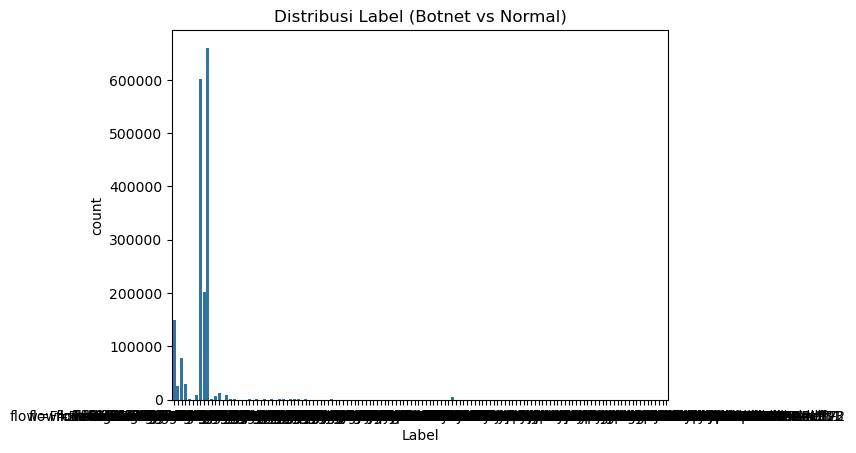

In [21]:
# Distribusi kelas
sns.countplot(data=df, x='Label')
plt.title('Distribusi Label (Botnet vs Normal)')
plt.show()

Data Cleaning

In [22]:
def clean_data(df):
    print("Jumlah data awal:", len(df))
    
    # 1. Handling Missing Values
    print("\nMissing values sebelum cleaning:")
    print(df.isnull().sum())
    
    # Fill missing values
    df['Sport'] = df['Sport'].fillna('unknown')
    df['Dport'] = df['Dport'].fillna('unknown')
    df['sTos'] = df['sTos'].fillna(df['sTos'].median())
    df['dTos'] = df['dTos'].fillna(df['dTos'].median())
    
    # 2. Remove Invalid Values
    df = df[df['Dur'] >= 0]
    df = df[~((df['TotBytes'] == 0) & (df['TotPkts'] > 0))]
    df = df[df['SrcBytes'] <= df['TotBytes']]
    
    # 3. Handle Outliers
    numeric_cols = ['Dur', 'TotPkts', 'TotBytes', 'SrcBytes']
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    # 4. Data Validation
    for col in numeric_cols:
        df[col] = df[col].abs()
    
    # 5. Convert Label ke format biner
    df['Label'] = df['Label'].apply(lambda x: 1 if 'Botnet' in x else 0)
    
    # 6. Remove duplicates if any
    df = df.drop_duplicates()
    
    print("\nMissing values setelah cleaning:")
    print(df.isnull().sum())
    print("\nJumlah data setelah cleaning:", len(df))
    
    # 7. Print class distribution
    print("\nDistribusi kelas setelah cleaning:")
    print(df['Label'].value_counts(normalize=True) * 100)
    
    return df

Focal Loss Implementation

In [23]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, dtype=K.floatx())
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred) + K.epsilon()
        loss = -alpha_t * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(loss)
    return focal_loss_fixed

Feature Engineering

In [24]:
def enhanced_feature_engineering(df):
    df['StartTime'] = pd.to_datetime(df['StartTime'])
    df['Hour'] = df['StartTime'].dt.hour
    df['Day'] = df['StartTime'].dt.day
    df['Month'] = df['StartTime'].dt.month
    df['DayOfWeek'] = df['StartTime'].dt.dayofweek
    df['IsWeekend'] = df['StartTime'].dt.dayofweek.isin([5, 6]).astype(int)
    df['BytesPerPacket'] = df['TotBytes'] / df['TotPkts'].replace(0, 1)
    df['BytesPerSecond'] = df['TotBytes'] / df['Dur'].replace(0, 1)
    df['PacketsPerSecond'] = df['TotPkts'] / df['Dur'].replace(0, 1)
    df['SrcBytesRatio'] = df['SrcBytes'] / df['TotBytes'].replace(0, 1)
    df['AvgDurPerPacket'] = df['Dur'] / df['TotPkts'].replace(0, 1)
    df['SrcToDstPktRatio'] = df['TotPkts'] / (df['SrcBytes'] + 1)
    for col in ['Proto', 'State', 'Dir']:
        temp_dict = df.groupby(col)['Label'].mean()
        df[f'{col}_encoded'] = df[col].map(temp_dict)
    return df

Data Preprocessing

In [25]:
def preprocess_data(df):
    features = [
        'Dur', 'Proto_encoded', 'State_encoded', 'Dir_encoded',
        'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes',
        'Hour', 'Day', 'Month', 'DayOfWeek', 'IsWeekend',
        'BytesPerPacket', 'BytesPerSecond', 'PacketsPerSecond',
        'SrcBytesRatio', 'AvgDurPerPacket', 'SrcToDstPktRatio'
    ]
    selector = SelectKBest(score_func=mutual_info_classif, k=15)
    X = selector.fit_transform(df[features], df['Label'])
    selected_features = np.array(features)[selector.get_support()]
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, df['Label'], selected_features, scaler

Create Deep Learning Model

In [26]:
def create_improved_model(input_dim, dropout_rate=0.4):
    keras_model = models.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim,
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate - 0.1),
        layers.Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate - 0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    initial_learning_rate = 0.001
    decay_steps = 1000
    decay_rate = 0.9
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps, decay_rate
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
    keras_model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )
    return keras_model

Precision-Recall Curve

In [27]:
def plot_pr_curve(y_true, y_pred_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Training with K-Fold Cross Validation

In [28]:
def train_with_kfold(X, y, n_splits=5):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    histories = []
    models = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f'\nFold {fold + 1}/{n_splits}')
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Apply SMOTETomek
        smt = SMOTETomek(random_state=42)
        X_train_balanced, y_train_balanced = smt.fit_resample(X_train, y_train)
        
        # Calculate class weights
        class_weights = dict(enumerate(np.bincount(y_train_balanced).max() / np.bincount(y_train_balanced)))
        
        # Create and train model
        model = create_improved_model(X_train.shape[1])
        
        history = model.fit(
            X_train_balanced, y_train_balanced,
            epochs=20,
            batch_size=256,
            verbose=0,
            validation_data=(X_val, y_val),
            class_weight=class_weights,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=3,
                    min_lr=1e-6
                )
            ]
        )
        
        histories.append(history.history)
        models.append(model)
    
    return models, histories

Main Pipeline

In [29]:
df = clean_data(df)
df = enhanced_feature_engineering(df)

X, y, selected_features, scaler = preprocess_data(df)

Jumlah data awal: 1808122

Missing values sebelum cleaning:
StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          3993
Dir               0
DstAddr           0
Dport          2973
State             0
sTos           4324
dTos         269835
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64

Missing values setelah cleaning:
StartTime    0
Dur          0
Proto        0
SrcAddr      0
Sport        0
Dir          0
DstAddr      0
Dport        0
State        0
sTos         0
dTos         0
TotPkts      0
TotBytes     0
SrcBytes     0
Label        0
dtype: int64

Jumlah data setelah cleaning: 1808122

Distribusi kelas setelah cleaning:
Label
0    98.841837
1     1.158163
Name: proportion, dtype: float64


Train model with k-fold

In [30]:
models, histories = train_with_kfold(X, y)


Fold 1/5


/home/ahmadzaki/anaconda3/envs/bismillah/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734900247.494391   43548 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734900247.537110   43548 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734900247.539452   43548 c


Fold 2/5


/home/ahmadzaki/anaconda3/envs/bismillah/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 3/5


/home/ahmadzaki/anaconda3/envs/bismillah/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 4/5


/home/ahmadzaki/anaconda3/envs/bismillah/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 5/5


/home/ahmadzaki/anaconda3/envs/bismillah/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


best model based on validation metrics and final predictions

56504/56504 ━━━━━━━━━━━━━━━━━━━━ 36s 629us/step


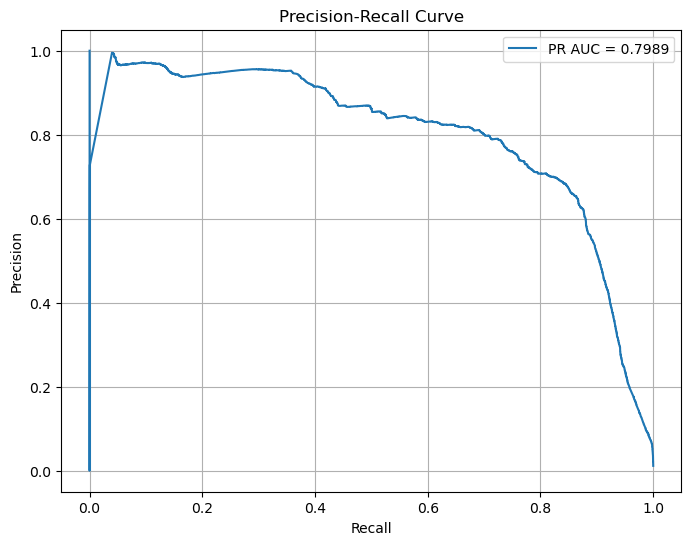

In [31]:
best_model_idx = np.argmax([h['val_accuracy'][-1] for h in histories])
best_model = models[best_model_idx]

y_pred_probs = best_model.predict(X).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)
plot_pr_curve(y, y_pred_probs)

In [32]:
print("\nFinal Classification Report:")
print(classification_report(y, y_pred))


Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1787181
           1       0.47      0.91      0.62     20941

    accuracy                           0.99   1808122
   macro avg       0.73      0.95      0.81   1808122
weighted avg       0.99      0.99      0.99   1808122



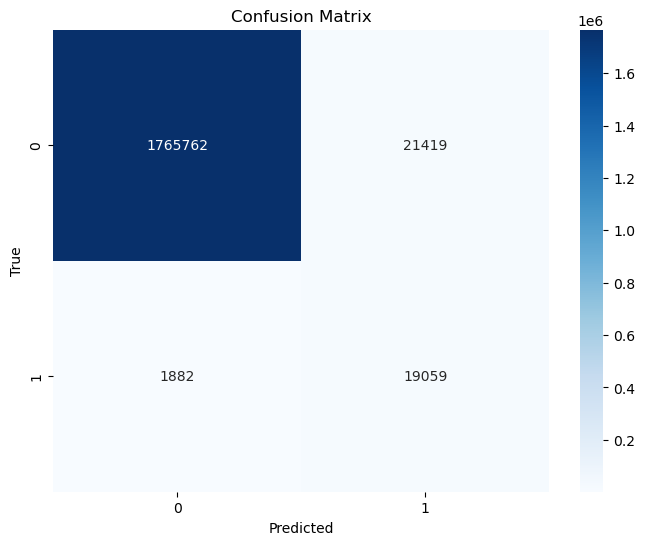

In [33]:
# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [34]:
best_model.save('models/fcnn_smotetomek_adam_kfold_focal_loss_lrscheduler_l1l2_regularizer.h5')
print("Model saved at 'models/fcnn_smotetomek_adam_kfold_focal_loss_lrscheduler_l1l2_regularizer.h5'")

Model saved at 'models/fcnn_smotetomek_adam_kfold_focal_loss_lrscheduler_l1l2_regularizer.h5'
